## ICU Length of stay using LightGBM Model  & Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv
#/content/gdrive/MyDrive/Colab Notebooks/covid/100k_synthea_covid19_csv/allergies.csv

In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Respiratory_rate,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Body_Weight,patient's_observation_of_Heart_rate,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_MCHC_Massvolume_by_Automated_count,patient's_observation_of_MCV_Entitic_volume_by_Automated_count,...,patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count,patient's_observation_of_Chloride_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Eosinophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Bilirubintotal_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Eosinophils100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Urea_nitrogen_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils_volume_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
236231,2dd9c18b-3d21-4b72-8aea-6b8eee30625e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Heart_rate,2,2
2933180,a02bba83-cc25-4500-b655-ef52e0ec1d6f,0,0,111.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Systolic_Blood_Pressure,1,1
8752356,92647349-f9e8-4e02-a854-385997f84484,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Albumin_Massvolume_in_Serum_or_Plasma,4,4
13079336,814993f8-3cf6-44fd-82ac-a7a495744af7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Leukocytes_volume_in_Blood_by_Automated_count,1,1
7152665,3851fa3a-2ffd-4bfb-9a2e-1cc28c57166a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Neutrophils100_leukocytes_in_Blood_by_Automate...,1,1


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 745 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-02,2020-03-21,94aa57c1-86a9-4afa-8f72-d81e4f604240,M,white,nonhispanic,F,North Andover,Essex County,0.013065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_MCHC_Massvolume_by_Automated_count",
 "patient's_observation_of_MCV_Entitic_volume_by_Automated_count",
 "patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted",
 "patient's_observation_of_Erythrocytes_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "patient's_observation_o

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

## LightGBM

##### Let's start with initial LightGBM model. After seeing the feature importance plot, we will reduce features to top 20. Then we will see if it performs better with top20 features

In [55]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [56]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.5262406845453915

In [57]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.7906315777977757

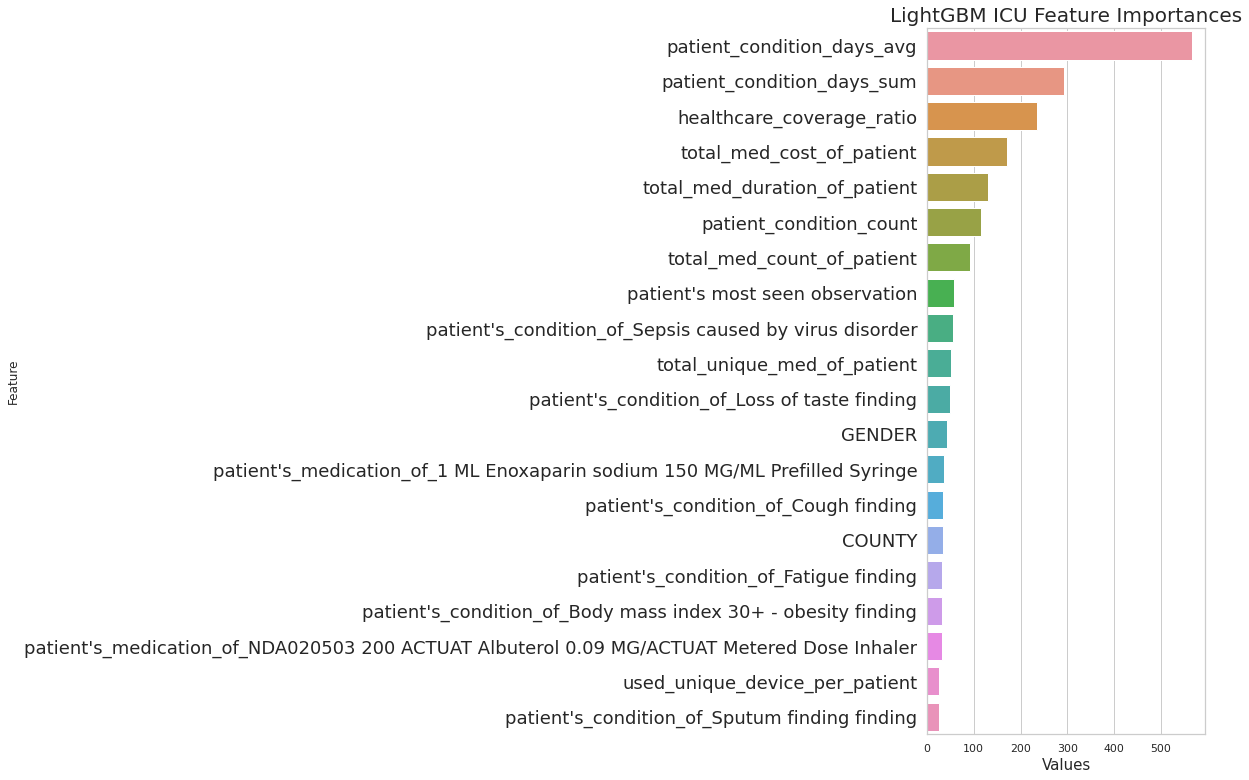

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [59]:
top20_features = feature_imp.sort_values("Value", ascending = False)[:20].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top20_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [60]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [61]:
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.5387465039379173

In [62]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_rmse

1.8416563694287387

#### It's indeed performing a bit better than initial model, by looking at both validation and test result we can say that

#### Let's tune some hyperparameters!

In [63]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = KFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'reg_lambda': 1.5, 'num_leaves': 4, 'num_iterations': 100, 'min_child_weight': 1, 'max_depth': 10, 'colsample_bytree': 0.7}


{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}

In [64]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Validation Result {}".format(val_result2))
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)
print("Test Result {}".format(lgb_tuned_rmse))

Validation Result 1.3997219558008014
Test Result 1.9509418370716245


In [65]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

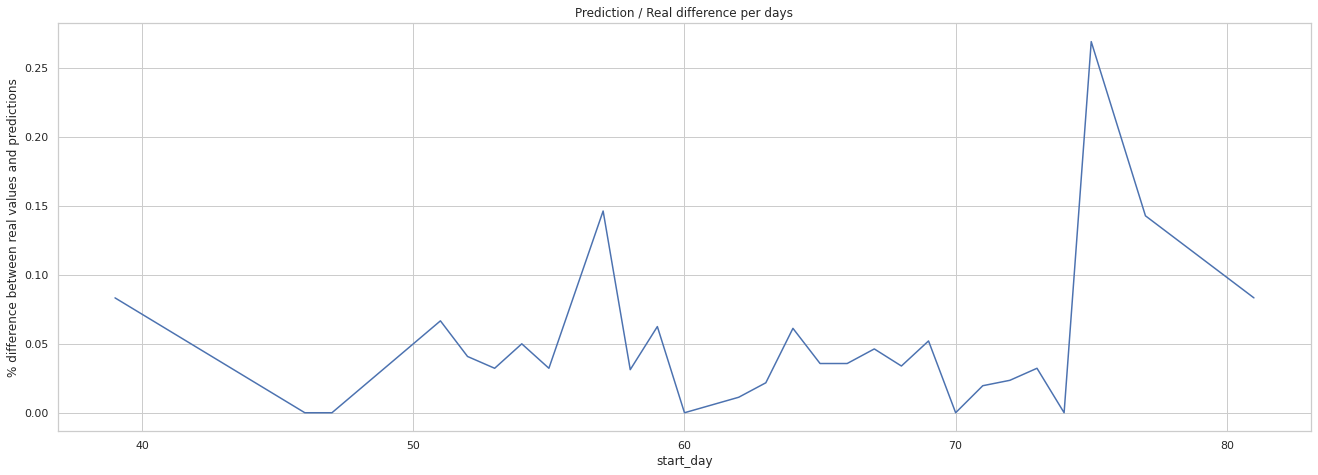

In [66]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

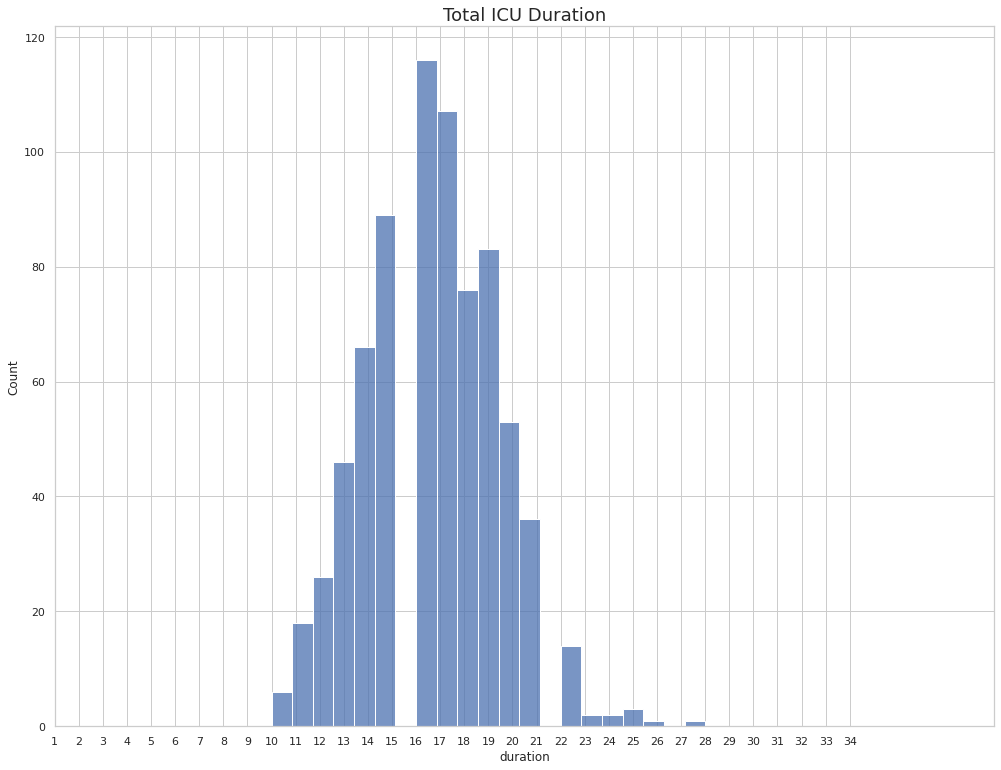

In [67]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

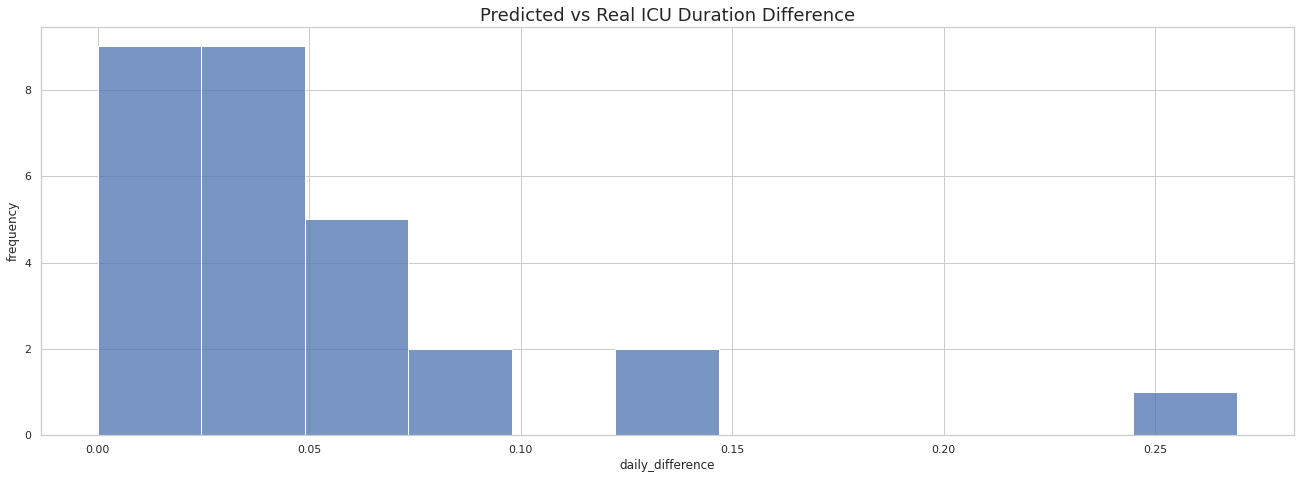

In [68]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

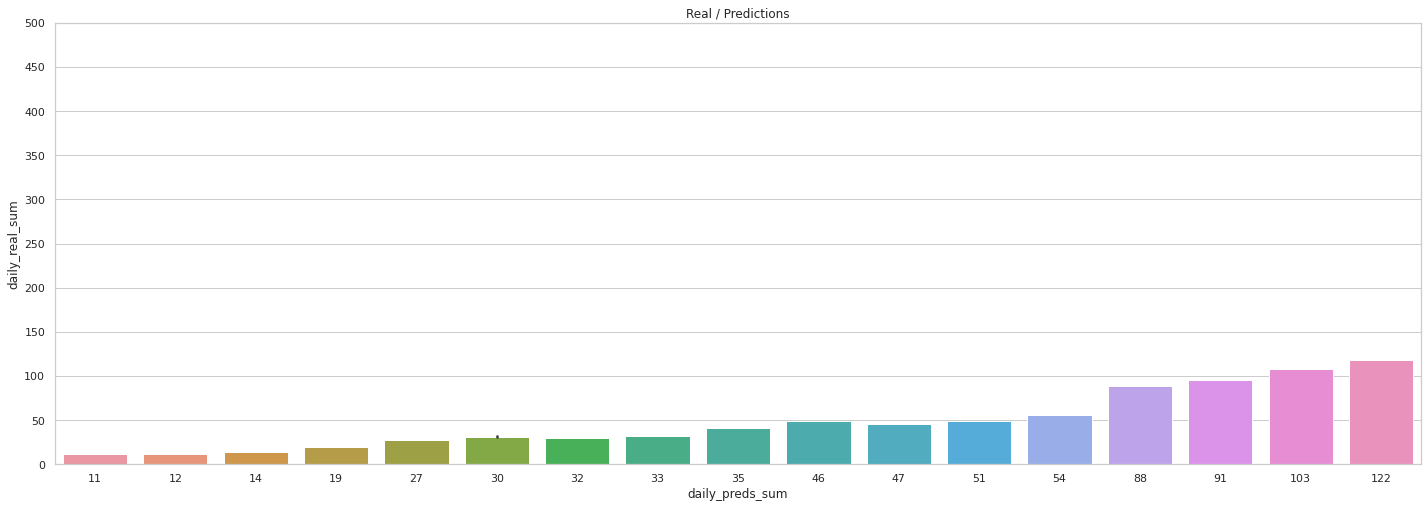

In [69]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

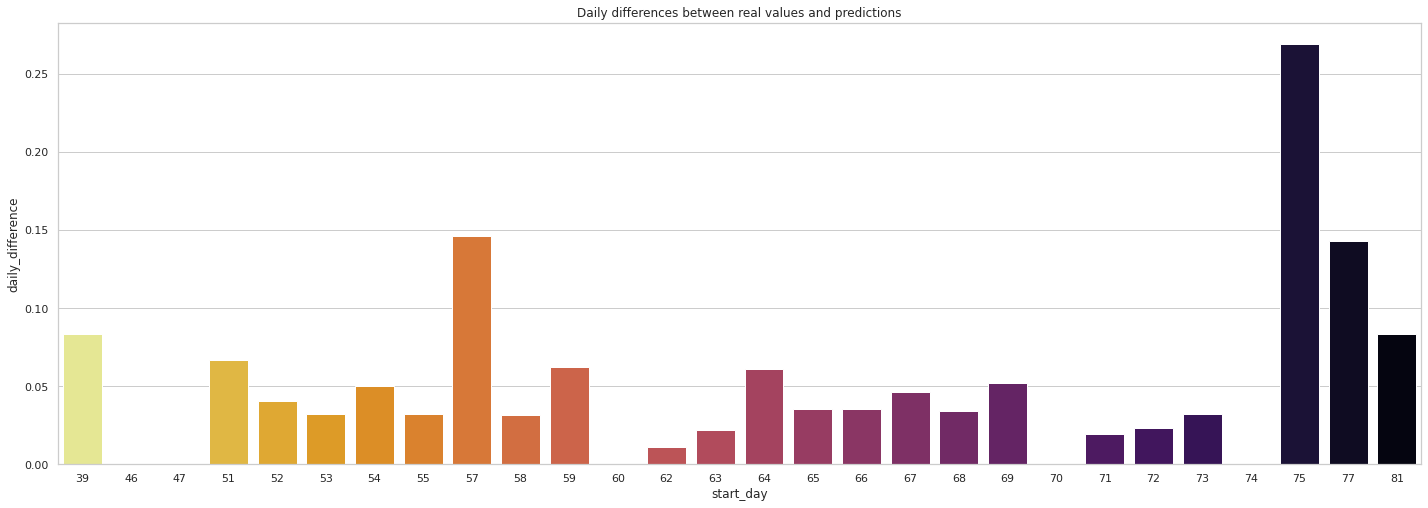

In [70]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [71]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00


In [72]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [74]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [75]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [76]:
y = data['duration']
LABEL = "duration"

In [77]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [78]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [79]:
CATEGORICAL_FEATURES

["patient's most seen observation", 'GENDER', 'COUNTY']

In [80]:
NUMERIC_FEATURES

['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'total_med_cost_of_patient',
 'total_med_duration_of_patient',
 'patient_condition_count',
 'total_med_count_of_patient',
 "patient's_condition_of_Sepsis caused by virus disorder",
 'total_unique_med_of_patient',
 "patient's_condition_of_Loss of taste finding",
 "patient's_medication_of_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_medication_of_NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler",
 'used_unique_device_per_patient',
 "patient's_condition_of_Sputum finding finding"]

In [81]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [82]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [83]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [84]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [85]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 15s 1s/step - loss: 287.8104 - output_loss: 287.8104 - output_rmse: 16.9650 - val_loss: 200.1986 - val_output_loss: 200.1986 - val_output_rmse: 14.1492
Epoch 2/150
2/2 [==============================] - 0s 106ms/step - loss: 255.3794 - output_loss: 255.3794 - output_rmse: 15.9806 - val_loss: 174.3970 - val_output_loss: 174.3970 - val_output_rmse: 13.2059
Epoch 3/150
2/2 [==============================] - 0s 83ms/step - loss: 211.9979 - output_loss: 211.9979 - output_rmse: 14.5601 - val_loss: 155.8255 - val_output_loss: 155.8255 - val_output_rmse: 12.4830
Epoch 4/150
2/2 [==============================] - 0s 92ms/step - loss: 186.0205 - output_loss: 186.0205 - output_rmse: 13.6389 - val_loss: 140.1663 - val_output_loss: 140.1663 - val_output_rmse: 11.8392
Epoch 5/150
2/2 [==============================] - 0s 80ms/step - loss: 166.8303 - output_loss: 166.8303 - output_rmse: 12.9163 - val_loss: 128.0853 - val_output_loss: 128.0853 - val_o

In [86]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
2/2 [==============================] - 6s 748ms/step - loss: 286.0678 - output_loss: 286.0678 - output_rmse: 16.9135 - val_loss: 247.4403 - val_output_loss: 247.4403 - val_output_rmse: 15.7302
Epoch 2/150
2/2 [==============================] - 0s 53ms/step - loss: 280.5294 - output_loss: 280.5294 - output_rmse: 16.7490 - val_loss: 228.7258 - val_output_loss: 228.7258 - val_output_rmse: 15.1237
Epoch 3/150
2/2 [==============================] - 0s 52ms/step - loss: 269.8774 - output_loss: 269.8774 - output_rmse: 16.4279 - val_loss: 215.9719 - val_output_loss: 215.9719 - val_output_rmse: 14.6960
Epoch 4/150
2/2 [==============================] - 0s 46ms/step - loss: 259.8834 - output_loss: 259.8834 - output_rmse: 16.1209 - val_loss: 208.5242 - val_output_loss: 208.5242 - val_output_rmse: 14.4404
Epoch 5/150
2/2 [==============================] - 0s 56ms/step - loss: 248.9306 - output_loss: 248.9306 - output_rmse: 15.7775 - val_loss: 203.1248 - val_output_loss: 203.1248 - val_

In [87]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 600ms/step


In [88]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.2 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [89]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 03:05:30,909] A new study created in memory with name: no-name-06cb5712-5b1d-4e9f-8bba-6a8692d5a28a


Epoch 1/150
2/2 [==============================] - 3s 468ms/step - loss: 286.9339 - output_loss: 286.9339 - output_rmse: 16.9391 - val_loss: 220.2221 - val_output_loss: 220.2221 - val_output_rmse: 14.8399
Epoch 2/150
2/2 [==============================] - 0s 35ms/step - loss: 262.3244 - output_loss: 262.3244 - output_rmse: 16.1964 - val_loss: 181.6044 - val_output_loss: 181.6044 - val_output_rmse: 13.4761
Epoch 3/150
2/2 [==============================] - 0s 37ms/step - loss: 230.2480 - output_loss: 230.2480 - output_rmse: 15.1739 - val_loss: 163.6060 - val_output_loss: 163.6060 - val_output_rmse: 12.7909
Epoch 4/150
2/2 [==============================] - 0s 35ms/step - loss: 210.3394 - output_loss: 210.3394 - output_rmse: 14.5031 - val_loss: 150.7584 - val_output_loss: 150.7584 - val_output_rmse: 12.2784
Epoch 5/150
2/2 [==============================] - 0s 34ms/step - loss: 197.4530 - output_loss: 197.4530 - output_rmse: 14.0518 - val_loss: 140.7197 - val_output_loss: 140.7197 - val_

[I 2023-01-26 03:05:40,343] Trial 0 finished with value: 3.3848332026909502 and parameters: {'numerical_bins': 35, 'embedding_dim': 53, 'depth': 1, 'heads': 3, 'attn_dropout': 0.29550425340836306, 'ff_dropout': 0.49737297661262403}. Best is trial 0 with value: 3.3848332026909502.


Epoch 1/150
2/2 [==============================] - 11s 1s/step - loss: 247.7102 - output_loss: 247.7102 - output_rmse: 15.7388 - val_loss: 75.6760 - val_output_loss: 75.6760 - val_output_rmse: 8.6992
Epoch 2/150
2/2 [==============================] - 0s 100ms/step - loss: 108.4200 - output_loss: 108.4200 - output_rmse: 10.4125 - val_loss: 38.6743 - val_output_loss: 38.6743 - val_output_rmse: 6.2189
Epoch 3/150
2/2 [==============================] - 0s 112ms/step - loss: 59.0982 - output_loss: 59.0982 - output_rmse: 7.6875 - val_loss: 23.4823 - val_output_loss: 23.4823 - val_output_rmse: 4.8459
Epoch 4/150
2/2 [==============================] - 0s 73ms/step - loss: 36.3622 - output_loss: 36.3622 - output_rmse: 6.0301 - val_loss: 15.8770 - val_output_loss: 15.8770 - val_output_rmse: 3.9846
Epoch 5/150
2/2 [==============================] - 0s 77ms/step - loss: 24.3236 - output_loss: 24.3236 - output_rmse: 4.9319 - val_loss: 12.0580 - val_output_loss: 12.0580 - val_output_rmse: 3.4725
Epo

[I 2023-01-26 03:05:56,412] Trial 1 finished with value: 3.377159670749885 and parameters: {'numerical_bins': 86, 'embedding_dim': 78, 'depth': 5, 'heads': 4, 'attn_dropout': 0.35052192047712544, 'ff_dropout': 0.20119887221624772}. Best is trial 1 with value: 3.377159670749885.


Epoch 1/150
2/2 [==============================] - 6s 751ms/step - loss: 281.7306 - output_loss: 281.7306 - output_rmse: 16.7848 - val_loss: 249.7970 - val_output_loss: 249.7970 - val_output_rmse: 15.8050
Epoch 2/150
2/2 [==============================] - 0s 50ms/step - loss: 277.4393 - output_loss: 277.4393 - output_rmse: 16.6565 - val_loss: 238.6360 - val_output_loss: 238.6360 - val_output_rmse: 15.4478
Epoch 3/150
2/2 [==============================] - 0s 52ms/step - loss: 270.2096 - output_loss: 270.2096 - output_rmse: 16.4381 - val_loss: 224.5384 - val_output_loss: 224.5384 - val_output_rmse: 14.9846
Epoch 4/150
2/2 [==============================] - 0s 53ms/step - loss: 261.6969 - output_loss: 261.6969 - output_rmse: 16.1770 - val_loss: 211.5144 - val_output_loss: 211.5144 - val_output_rmse: 14.5435
Epoch 5/150
2/2 [==============================] - 0s 57ms/step - loss: 253.2343 - output_loss: 253.2343 - output_rmse: 15.9133 - val_loss: 201.8829 - val_output_loss: 201.8829 - val_

1/1 [==============================] - 1s 628ms/step


[I 2023-01-26 03:06:14,949] Trial 2 finished with value: 3.365412527289619 and parameters: {'numerical_bins': 116, 'embedding_dim': 13, 'depth': 3, 'heads': 2, 'attn_dropout': 0.10976290844366804, 'ff_dropout': 0.43506809979491207}. Best is trial 2 with value: 3.365412527289619.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 274.3518 - output_loss: 274.3518 - output_rmse: 16.5636 - val_loss: 160.2780 - val_output_loss: 160.2780 - val_output_rmse: 12.6601
Epoch 2/150
2/2 [==============================] - 0s 93ms/step - loss: 209.2697 - output_loss: 209.2697 - output_rmse: 14.4662 - val_loss: 126.9828 - val_output_loss: 126.9828 - val_output_rmse: 11.2687
Epoch 3/150
2/2 [==============================] - 0s 84ms/step - loss: 168.5725 - output_loss: 168.5725 - output_rmse: 12.9835 - val_loss: 96.4269 - val_output_loss: 96.4269 - val_output_rmse: 9.8197
Epoch 4/150
2/2 [==============================] - 0s 90ms/step - loss: 135.9609 - output_loss: 135.9609 - output_rmse: 11.6602 - val_loss: 78.3325 - val_output_loss: 78.3325 - val_output_rmse: 8.8506
Epoch 5/150
2/2 [==============================] - 0s 83ms/step - loss: 111.8927 - output_loss: 111.8927 - output_rmse: 10.5779 - val_loss: 66.3924 - val_output_loss: 66.3924 - val_output_rms

1/1 [==============================] - 1s 989ms/step


[I 2023-01-26 03:06:32,788] Trial 3 finished with value: 3.329178722089118 and parameters: {'numerical_bins': 199, 'embedding_dim': 58, 'depth': 6, 'heads': 2, 'attn_dropout': 0.056897663971288204, 'ff_dropout': 0.39350084490846793}. Best is trial 3 with value: 3.329178722089118.


Epoch 1/150
2/2 [==============================] - 6s 730ms/step - loss: 222.2757 - output_loss: 222.2757 - output_rmse: 14.9089 - val_loss: 167.0257 - val_output_loss: 167.0257 - val_output_rmse: 12.9238
Epoch 2/150
2/2 [==============================] - 0s 57ms/step - loss: 198.7565 - output_loss: 198.7565 - output_rmse: 14.0981 - val_loss: 154.4827 - val_output_loss: 154.4827 - val_output_rmse: 12.4291
Epoch 3/150
2/2 [==============================] - 0s 51ms/step - loss: 184.7713 - output_loss: 184.7713 - output_rmse: 13.5931 - val_loss: 147.7582 - val_output_loss: 147.7582 - val_output_rmse: 12.1556
Epoch 4/150
2/2 [==============================] - 0s 55ms/step - loss: 175.6796 - output_loss: 175.6796 - output_rmse: 13.2544 - val_loss: 141.5618 - val_output_loss: 141.5618 - val_output_rmse: 11.8980
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 168.4556 - output_loss: 168.4556 - output_rmse: 12.9790 - val_loss: 135.1691 - val_output_loss: 135.1691 - val_

[I 2023-01-26 03:06:47,599] Trial 4 finished with value: 3.362981296378989 and parameters: {'numerical_bins': 25, 'embedding_dim': 18, 'depth': 3, 'heads': 5, 'attn_dropout': 0.33981138144406964, 'ff_dropout': 0.18627544097786752}. Best is trial 3 with value: 3.329178722089118.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 258.6301 - output_loss: 258.6301 - output_rmse: 16.0820 - val_loss: 91.0056 - val_output_loss: 91.0056 - val_output_rmse: 9.5397
Epoch 2/150
2/2 [==============================] - 0s 82ms/step - loss: 140.5130 - output_loss: 140.5130 - output_rmse: 11.8538 - val_loss: 54.9195 - val_output_loss: 54.9195 - val_output_rmse: 7.4108
Epoch 3/150
2/2 [==============================] - 0s 87ms/step - loss: 90.1307 - output_loss: 90.1307 - output_rmse: 9.4937 - val_loss: 39.7701 - val_output_loss: 39.7701 - val_output_rmse: 6.3064
Epoch 4/150
2/2 [==============================] - 0s 80ms/step - loss: 61.9513 - output_loss: 61.9513 - output_rmse: 7.8709 - val_loss: 33.0941 - val_output_loss: 33.0941 - val_output_rmse: 5.7527
Epoch 5/150
2/2 [==============================] - 0s 79ms/step - loss: 47.9665 - output_loss: 47.9665 - output_rmse: 6.9258 - val_loss: 27.7537 - val_output_loss: 27.7537 - val_output_rmse: 5.2682
Epoch 

[I 2023-01-26 03:07:04,307] Trial 5 finished with value: 3.3492109634537015 and parameters: {'numerical_bins': 177, 'embedding_dim': 83, 'depth': 5, 'heads': 8, 'attn_dropout': 0.15466843873033742, 'ff_dropout': 0.44584705291017973}. Best is trial 3 with value: 3.329178722089118.


Epoch 1/150
2/2 [==============================] - 4s 597ms/step - loss: 277.3610 - output_loss: 277.3610 - output_rmse: 16.6542 - val_loss: 156.2618 - val_output_loss: 156.2618 - val_output_rmse: 12.5005
Epoch 2/150
2/2 [==============================] - 0s 51ms/step - loss: 188.9974 - output_loss: 188.9974 - output_rmse: 13.7476 - val_loss: 115.5455 - val_output_loss: 115.5455 - val_output_rmse: 10.7492
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 147.5235 - output_loss: 147.5235 - output_rmse: 12.1459 - val_loss: 76.9632 - val_output_loss: 76.9632 - val_output_rmse: 8.7729
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 108.0852 - output_loss: 108.0852 - output_rmse: 10.3964 - val_loss: 52.2225 - val_output_loss: 52.2225 - val_output_rmse: 7.2265
Epoch 5/150
2/2 [==============================] - 0s 51ms/step - loss: 75.9477 - output_loss: 75.9477 - output_rmse: 8.7148 - val_loss: 39.1188 - val_output_loss: 39.1188 - val_output_rmse

[I 2023-01-26 03:07:13,589] Trial 6 finished with value: 3.3989257396853145 and parameters: {'numerical_bins': 83, 'embedding_dim': 91, 'depth': 2, 'heads': 7, 'attn_dropout': 0.23958631401165226, 'ff_dropout': 0.2759731755881449}. Best is trial 3 with value: 3.329178722089118.


Epoch 1/150
2/2 [==============================] - 4s 611ms/step - loss: 284.3315 - output_loss: 284.3315 - output_rmse: 16.8621 - val_loss: 153.9507 - val_output_loss: 153.9507 - val_output_rmse: 12.4077
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 193.2192 - output_loss: 193.2192 - output_rmse: 13.9003 - val_loss: 117.2657 - val_output_loss: 117.2657 - val_output_rmse: 10.8289
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 153.0664 - output_loss: 153.0664 - output_rmse: 12.3720 - val_loss: 101.5761 - val_output_loss: 101.5761 - val_output_rmse: 10.0785
Epoch 4/150
2/2 [==============================] - 0s 50ms/step - loss: 130.9234 - output_loss: 130.9234 - output_rmse: 11.4422 - val_loss: 90.1010 - val_output_loss: 90.1010 - val_output_rmse: 9.4922
Epoch 5/150
2/2 [==============================] - 0s 49ms/step - loss: 115.9479 - output_loss: 115.9479 - output_rmse: 10.7679 - val_loss: 79.7891 - val_output_loss: 79.7891 - val_outpu

[I 2023-01-26 03:07:24,688] Trial 7 finished with value: 3.3852546896089253 and parameters: {'numerical_bins': 172, 'embedding_dim': 69, 'depth': 2, 'heads': 5, 'attn_dropout': 0.4292020118965182, 'ff_dropout': 0.17307598706009608}. Best is trial 3 with value: 3.329178722089118.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 282.8276 - output_loss: 282.8276 - output_rmse: 16.8175 - val_loss: 145.3717 - val_output_loss: 145.3717 - val_output_rmse: 12.0570
Epoch 2/150
2/2 [==============================] - 0s 83ms/step - loss: 203.8948 - output_loss: 203.8948 - output_rmse: 14.2792 - val_loss: 108.8972 - val_output_loss: 108.8972 - val_output_rmse: 10.4354
Epoch 3/150
2/2 [==============================] - 0s 81ms/step - loss: 151.4330 - output_loss: 151.4330 - output_rmse: 12.3058 - val_loss: 88.7140 - val_output_loss: 88.7140 - val_output_rmse: 9.4188
Epoch 4/150
2/2 [==============================] - 0s 79ms/step - loss: 122.1890 - output_loss: 122.1890 - output_rmse: 11.0539 - val_loss: 76.9636 - val_output_loss: 76.9636 - val_output_rmse: 8.7729
Epoch 5/150
2/2 [==============================] - 0s 82ms/step - loss: 102.0467 - output_loss: 102.0467 - output_rmse: 10.1018 - val_loss: 68.8454 - val_output_loss: 68.8454 - val_output_rmse

[I 2023-01-26 03:07:42,665] Trial 8 finished with value: 3.3661379357268904 and parameters: {'numerical_bins': 73, 'embedding_dim': 81, 'depth': 5, 'heads': 4, 'attn_dropout': 0.149435471798592, 'ff_dropout': 0.46617070157468227}. Best is trial 3 with value: 3.329178722089118.


Epoch 1/150
2/2 [==============================] - 6s 741ms/step - loss: 220.9777 - output_loss: 220.9777 - output_rmse: 14.8653 - val_loss: 105.5795 - val_output_loss: 105.5795 - val_output_rmse: 10.2752
Epoch 2/150
2/2 [==============================] - 0s 58ms/step - loss: 127.9004 - output_loss: 127.9004 - output_rmse: 11.3093 - val_loss: 79.9473 - val_output_loss: 79.9473 - val_output_rmse: 8.9413
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 98.2361 - output_loss: 98.2361 - output_rmse: 9.9114 - val_loss: 63.2414 - val_output_loss: 63.2414 - val_output_rmse: 7.9524
Epoch 4/150
2/2 [==============================] - 0s 58ms/step - loss: 79.3736 - output_loss: 79.3736 - output_rmse: 8.9092 - val_loss: 52.7435 - val_output_loss: 52.7435 - val_output_rmse: 7.2625
Epoch 5/150
2/2 [==============================] - 0s 65ms/step - loss: 67.1231 - output_loss: 67.1231 - output_rmse: 8.1929 - val_loss: 46.5790 - val_output_loss: 46.5790 - val_output_rmse: 6.8249


[I 2023-01-26 03:07:53,798] Trial 9 finished with value: 3.381666880222508 and parameters: {'numerical_bins': 178, 'embedding_dim': 84, 'depth': 3, 'heads': 3, 'attn_dropout': 0.3497958884949097, 'ff_dropout': 0.047554852986405216}. Best is trial 3 with value: 3.329178722089118.


Number of finished trials: 10
Best trial: {'numerical_bins': 199, 'embedding_dim': 58, 'depth': 6, 'heads': 2, 'attn_dropout': 0.056897663971288204, 'ff_dropout': 0.39350084490846793}


In [90]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=199,
    embedding_dim=58,
    depth=1,
    heads=6,
    attn_dropout= 0.0463,
    ff_dropout= 0.0861,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 4s 778ms/step - loss: 246.4773 - output_loss: 246.4773 - output_rmse: 15.6996 - val_loss: 118.7704 - val_output_loss: 118.7704 - val_output_rmse: 10.8982
Epoch 2/250
2/2 [==============================] - 0s 56ms/step - loss: 142.0957 - output_loss: 142.0957 - output_rmse: 11.9204 - val_loss: 71.5623 - val_output_loss: 71.5623 - val_output_rmse: 8.4594
Epoch 3/250
2/2 [==============================] - 0s 53ms/step - loss: 89.6505 - output_loss: 89.6505 - output_rmse: 9.4684 - val_loss: 53.9521 - val_output_loss: 53.9521 - val_output_rmse: 7.3452
Epoch 4/250
2/2 [==============================] - 0s 47ms/step - loss: 70.0177 - output_loss: 70.0177 - output_rmse: 8.3677 - val_loss: 43.2174 - val_output_loss: 43.2174 - val_output_rmse: 6.5740
Epoch 5/250
2/2 [==============================] - 0s 44ms/step - loss: 57.8117 - output_loss: 57.8117 - output_rmse: 7.6034 - val_loss: 35.7390 - val_output_loss: 35.7390 - val_output_rmse: 5.9782


In [91]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 518ms/step


### Periodic Encoding FT Transformer Model Graphs

In [92]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

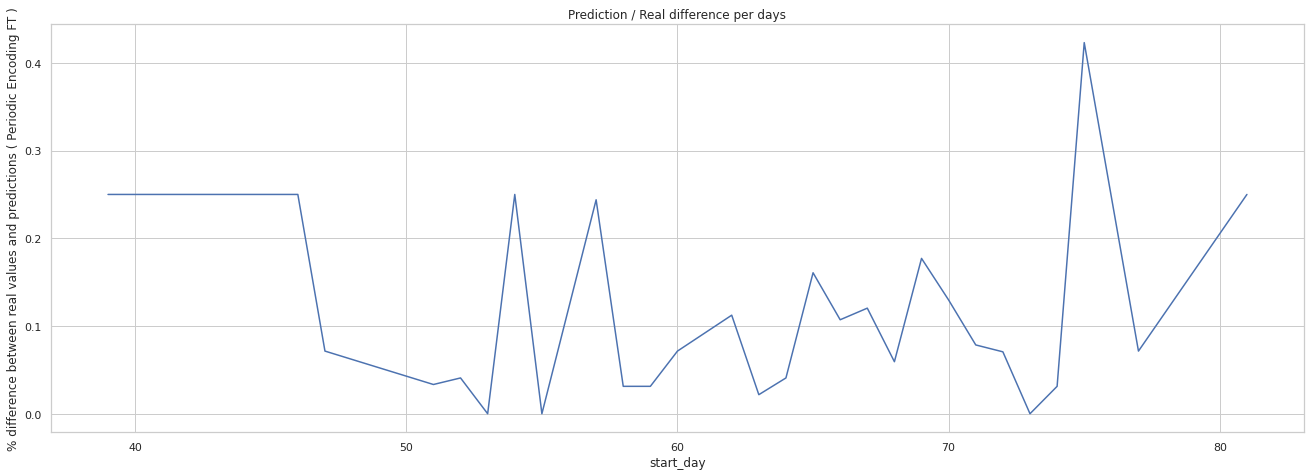

In [93]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

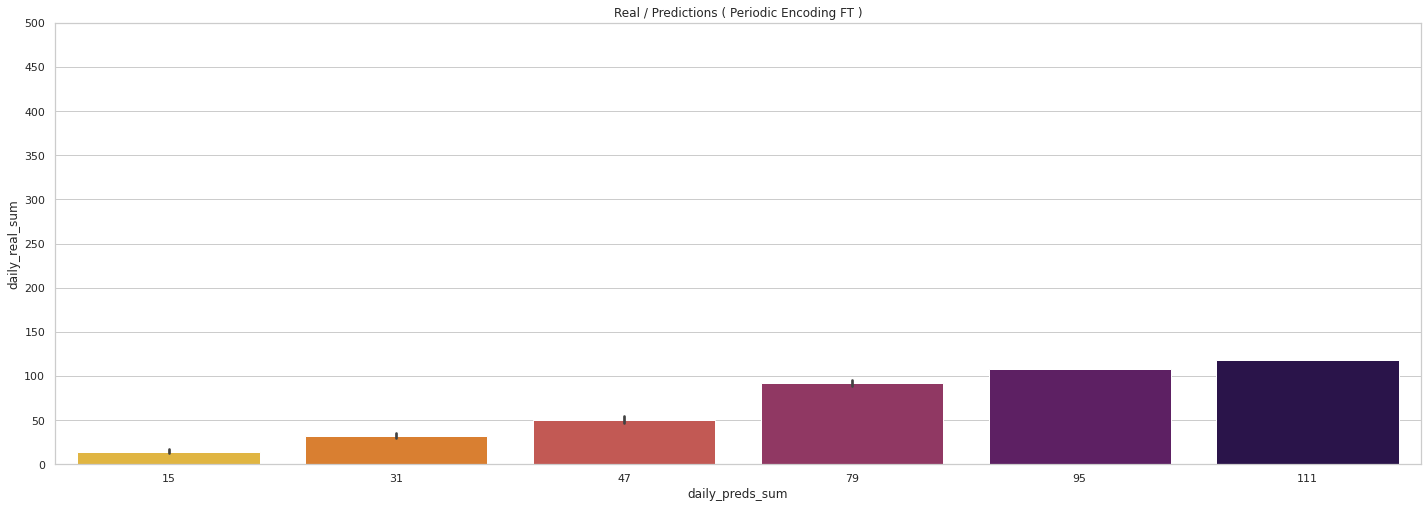

In [94]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

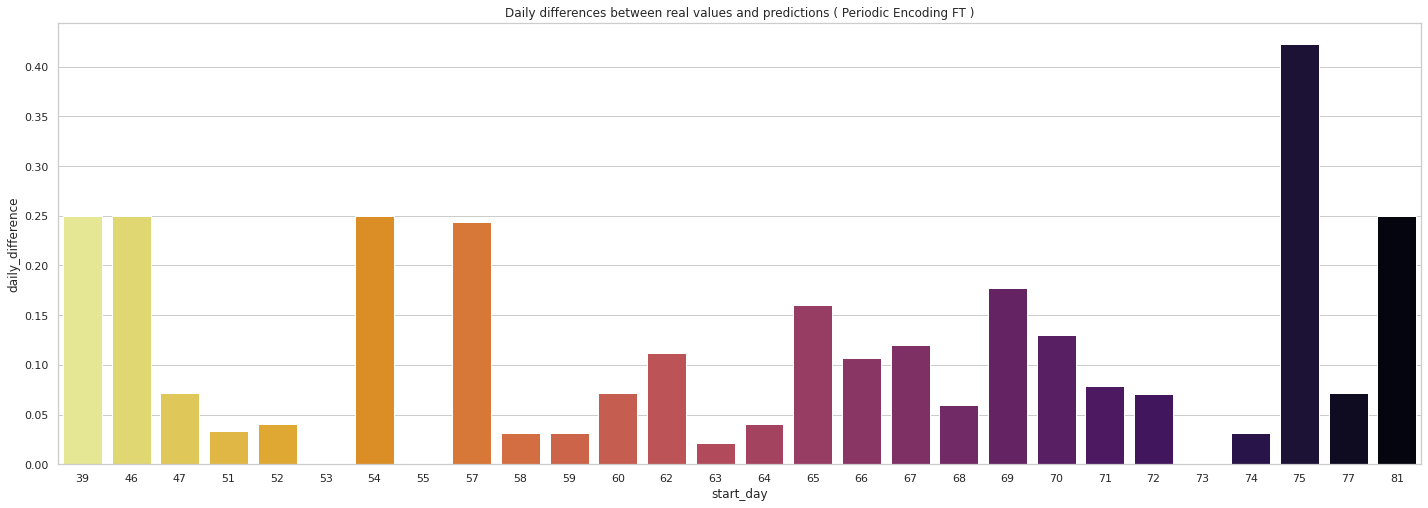

In [95]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [96]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-26 03:09:01,354] A new study created in memory with name: no-name-e1a5740d-311c-4315-b004-21e8ab9dc539


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 232.7495 - output_loss: 232.7495 - output_rmse: 15.2561 - val_loss: 83.1059 - val_output_loss: 83.1059 - val_output_rmse: 9.1162
Epoch 2/150
2/2 [==============================] - 0s 76ms/step - loss: 103.8764 - output_loss: 103.8764 - output_rmse: 10.1920 - val_loss: 47.5584 - val_output_loss: 47.5584 - val_output_rmse: 6.8963
Epoch 3/150
2/2 [==============================] - 0s 78ms/step - loss: 61.4944 - output_loss: 61.4944 - output_rmse: 7.8418 - val_loss: 34.4515 - val_output_loss: 34.4515 - val_output_rmse: 5.8695
Epoch 4/150
2/2 [==============================] - 0s 80ms/step - loss: 45.7975 - output_loss: 45.7975 - output_rmse: 6.7674 - val_loss: 27.5702 - val_output_loss: 27.5702 - val_output_rmse: 5.2507
Epoch 5/150
2/2 [==============================] - 0s 71ms/step - loss: 36.6498 - output_loss: 36.6498 - output_rmse: 6.0539 - val_loss: 22.5332 - val_output_loss: 22.5332 - val_output_rmse: 4.7469
Epoch 

[I 2023-01-26 03:09:15,657] Trial 0 finished with value: 3.3720462218427345 and parameters: {'numerical_bins': 29, 'embedding_dim': 57, 'depth': 5, 'heads': 2, 'attn_dropout': 0.05176116178684226, 'ff_dropout': 0.06021723694233544}. Best is trial 0 with value: 3.3720462218427345.


Epoch 1/150
2/2 [==============================] - 7s 914ms/step - loss: 275.1345 - output_loss: 275.1345 - output_rmse: 16.5872 - val_loss: 149.5989 - val_output_loss: 149.5989 - val_output_rmse: 12.2311
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 202.4307 - output_loss: 202.4307 - output_rmse: 14.2278 - val_loss: 86.1858 - val_output_loss: 86.1858 - val_output_rmse: 9.2836
Epoch 3/150
2/2 [==============================] - 0s 65ms/step - loss: 130.7316 - output_loss: 130.7316 - output_rmse: 11.4338 - val_loss: 63.4515 - val_output_loss: 63.4515 - val_output_rmse: 7.9656
Epoch 4/150
2/2 [==============================] - 0s 73ms/step - loss: 93.3439 - output_loss: 93.3439 - output_rmse: 9.6615 - val_loss: 51.6533 - val_output_loss: 51.6533 - val_output_rmse: 7.1870
Epoch 5/150
2/2 [==============================] - 0s 63ms/step - loss: 73.5492 - output_loss: 73.5492 - output_rmse: 8.5761 - val_loss: 44.6752 - val_output_loss: 44.6752 - val_output_rmse: 6.68

[I 2023-01-26 03:09:29,683] Trial 1 finished with value: 3.3565861005214197 and parameters: {'numerical_bins': 127, 'embedding_dim': 45, 'depth': 4, 'heads': 7, 'attn_dropout': 0.18157803240758608, 'ff_dropout': 0.49509979002606186}. Best is trial 1 with value: 3.3565861005214197.


Epoch 1/150
2/2 [==============================] - 4s 603ms/step - loss: 276.0262 - output_loss: 276.0262 - output_rmse: 16.6140 - val_loss: 158.5427 - val_output_loss: 158.5427 - val_output_rmse: 12.5914
Epoch 2/150
2/2 [==============================] - 0s 48ms/step - loss: 203.2090 - output_loss: 203.2090 - output_rmse: 14.2551 - val_loss: 111.9747 - val_output_loss: 111.9747 - val_output_rmse: 10.5818
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 154.0475 - output_loss: 154.0475 - output_rmse: 12.4116 - val_loss: 68.3383 - val_output_loss: 68.3383 - val_output_rmse: 8.2667
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 107.0767 - output_loss: 107.0767 - output_rmse: 10.3478 - val_loss: 47.1012 - val_output_loss: 47.1012 - val_output_rmse: 6.8630
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 76.5098 - output_loss: 76.5098 - output_rmse: 8.7470 - val_loss: 36.0013 - val_output_loss: 36.0013 - val_output_rmse

[I 2023-01-26 03:09:38,497] Trial 2 finished with value: 3.3773707063081853 and parameters: {'numerical_bins': 192, 'embedding_dim': 60, 'depth': 2, 'heads': 3, 'attn_dropout': 0.0930435670458904, 'ff_dropout': 0.3792020336787899}. Best is trial 1 with value: 3.3565861005214197.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 268.9489 - output_loss: 268.9489 - output_rmse: 16.3997 - val_loss: 230.4845 - val_output_loss: 230.4845 - val_output_rmse: 15.1817
Epoch 2/150
2/2 [==============================] - 0s 73ms/step - loss: 258.3730 - output_loss: 258.3730 - output_rmse: 16.0740 - val_loss: 217.3210 - val_output_loss: 217.3210 - val_output_rmse: 14.7418
Epoch 3/150
2/2 [==============================] - 0s 71ms/step - loss: 248.3356 - output_loss: 248.3356 - output_rmse: 15.7587 - val_loss: 206.7626 - val_output_loss: 206.7626 - val_output_rmse: 14.3792
Epoch 4/150
2/2 [==============================] - 0s 68ms/step - loss: 238.6851 - output_loss: 238.6851 - output_rmse: 15.4494 - val_loss: 199.0515 - val_output_loss: 199.0515 - val_output_rmse: 14.1086
Epoch 5/150
2/2 [==============================] - 0s 69ms/step - loss: 230.4187 - output_loss: 230.4187 - output_rmse: 15.1795 - val_loss: 191.8450 - val_output_loss: 191.8450 - val_out

[I 2023-01-26 03:10:05,019] Trial 3 finished with value: 3.3560484404465 and parameters: {'numerical_bins': 148, 'embedding_dim': 12, 'depth': 5, 'heads': 6, 'attn_dropout': 0.35068016192782986, 'ff_dropout': 0.24354742665536994}. Best is trial 3 with value: 3.3560484404465.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 279.2202 - output_loss: 279.2202 - output_rmse: 16.7099 - val_loss: 207.9002 - val_output_loss: 207.9002 - val_output_rmse: 14.4187
Epoch 2/150
2/2 [==============================] - 0s 72ms/step - loss: 249.3768 - output_loss: 249.3768 - output_rmse: 15.7917 - val_loss: 185.5085 - val_output_loss: 185.5085 - val_output_rmse: 13.6201
Epoch 3/150
2/2 [==============================] - 0s 69ms/step - loss: 225.0423 - output_loss: 225.0423 - output_rmse: 15.0014 - val_loss: 174.1107 - val_output_loss: 174.1107 - val_output_rmse: 13.1951
Epoch 4/150
2/2 [==============================] - 0s 71ms/step - loss: 209.1122 - output_loss: 209.1122 - output_rmse: 14.4607 - val_loss: 164.7607 - val_output_loss: 164.7607 - val_output_rmse: 12.8359
Epoch 5/150
2/2 [==============================] - 0s 75ms/step - loss: 197.1291 - output_loss: 197.1291 - output_rmse: 14.0403 - val_loss: 157.6351 - val_output_loss: 157.6351 - val_out

[I 2023-01-26 03:10:27,290] Trial 4 finished with value: 3.368800278184959 and parameters: {'numerical_bins': 168, 'embedding_dim': 20, 'depth': 5, 'heads': 4, 'attn_dropout': 0.002112016832120811, 'ff_dropout': 0.30133564681054464}. Best is trial 3 with value: 3.3560484404465.


Epoch 1/150
2/2 [==============================] - 7s 918ms/step - loss: 287.1550 - output_loss: 287.1550 - output_rmse: 16.9456 - val_loss: 171.9910 - val_output_loss: 171.9910 - val_output_rmse: 13.1145
Epoch 2/150
2/2 [==============================] - 0s 78ms/step - loss: 192.6529 - output_loss: 192.6529 - output_rmse: 13.8799 - val_loss: 112.8113 - val_output_loss: 112.8113 - val_output_rmse: 10.6213
Epoch 3/150
2/2 [==============================] - 0s 71ms/step - loss: 129.9091 - output_loss: 129.9091 - output_rmse: 11.3978 - val_loss: 93.7085 - val_output_loss: 93.7085 - val_output_rmse: 9.6803
Epoch 4/150
2/2 [==============================] - 0s 69ms/step - loss: 109.2401 - output_loss: 109.2401 - output_rmse: 10.4518 - val_loss: 86.3633 - val_output_loss: 86.3633 - val_output_rmse: 9.2932
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 101.1243 - output_loss: 101.1243 - output_rmse: 10.0561 - val_loss: 82.0882 - val_output_loss: 82.0882 - val_output_r

[I 2023-01-26 03:10:44,189] Trial 5 finished with value: 3.378695741041648 and parameters: {'numerical_bins': 59, 'embedding_dim': 98, 'depth': 4, 'heads': 5, 'attn_dropout': 0.2806192619087705, 'ff_dropout': 0.0007090327099043559}. Best is trial 3 with value: 3.3560484404465.


Epoch 1/150
2/2 [==============================] - 7s 878ms/step - loss: 284.0743 - output_loss: 284.0743 - output_rmse: 16.8545 - val_loss: 205.6980 - val_output_loss: 205.6980 - val_output_rmse: 14.3422
Epoch 2/150
2/2 [==============================] - 0s 63ms/step - loss: 240.5653 - output_loss: 240.5653 - output_rmse: 15.5102 - val_loss: 172.1096 - val_output_loss: 172.1096 - val_output_rmse: 13.1191
Epoch 3/150
2/2 [==============================] - 0s 61ms/step - loss: 203.6918 - output_loss: 203.6918 - output_rmse: 14.2721 - val_loss: 139.6194 - val_output_loss: 139.6194 - val_output_rmse: 11.8161
Epoch 4/150
2/2 [==============================] - 0s 66ms/step - loss: 170.5318 - output_loss: 170.5318 - output_rmse: 13.0588 - val_loss: 114.7825 - val_output_loss: 114.7825 - val_output_rmse: 10.7137
Epoch 5/150
2/2 [==============================] - 0s 68ms/step - loss: 145.1565 - output_loss: 145.1565 - output_rmse: 12.0481 - val_loss: 102.4257 - val_output_loss: 102.4257 - val_

[I 2023-01-26 03:11:01,383] Trial 6 finished with value: 3.375911077956021 and parameters: {'numerical_bins': 158, 'embedding_dim': 29, 'depth': 4, 'heads': 7, 'attn_dropout': 0.49967917731874917, 'ff_dropout': 0.2183190738188529}. Best is trial 3 with value: 3.3560484404465.


Epoch 1/150
2/2 [==============================] - 4s 593ms/step - loss: 270.3669 - output_loss: 270.3669 - output_rmse: 16.4428 - val_loss: 94.0801 - val_output_loss: 94.0801 - val_output_rmse: 9.6995
Epoch 2/150
2/2 [==============================] - 0s 54ms/step - loss: 111.9751 - output_loss: 111.9751 - output_rmse: 10.5818 - val_loss: 30.3604 - val_output_loss: 30.3604 - val_output_rmse: 5.5100
Epoch 3/150
2/2 [==============================] - 0s 48ms/step - loss: 41.7086 - output_loss: 41.7086 - output_rmse: 6.4582 - val_loss: 12.6449 - val_output_loss: 12.6449 - val_output_rmse: 3.5560
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 18.3877 - output_loss: 18.3877 - output_rmse: 4.2881 - val_loss: 8.8775 - val_output_loss: 8.8775 - val_output_rmse: 2.9795
Epoch 5/150
2/2 [==============================] - 0s 52ms/step - loss: 11.5236 - output_loss: 11.5236 - output_rmse: 3.3946 - val_loss: 7.9911 - val_output_loss: 7.9911 - val_output_rmse: 2.8269
Epoch 6

[I 2023-01-26 03:11:12,179] Trial 7 finished with value: 2.1176233992313658 and parameters: {'numerical_bins': 54, 'embedding_dim': 86, 'depth': 2, 'heads': 3, 'attn_dropout': 0.36236386138286825, 'ff_dropout': 0.052691300971482946}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 233.5887 - output_loss: 233.5887 - output_rmse: 15.2836 - val_loss: 130.7295 - val_output_loss: 130.7295 - val_output_rmse: 11.4337
Epoch 2/150
2/2 [==============================] - 0s 78ms/step - loss: 149.9475 - output_loss: 149.9475 - output_rmse: 12.2453 - val_loss: 98.4860 - val_output_loss: 98.4860 - val_output_rmse: 9.9240
Epoch 3/150
2/2 [==============================] - 0s 87ms/step - loss: 115.6010 - output_loss: 115.6010 - output_rmse: 10.7518 - val_loss: 80.9682 - val_output_loss: 80.9682 - val_output_rmse: 8.9982
Epoch 4/150
2/2 [==============================] - 0s 71ms/step - loss: 96.3783 - output_loss: 96.3783 - output_rmse: 9.8172 - val_loss: 70.6662 - val_output_loss: 70.6662 - val_output_rmse: 8.4063
Epoch 5/150
2/2 [==============================] - 0s 77ms/step - loss: 84.9065 - output_loss: 84.9065 - output_rmse: 9.2145 - val_loss: 64.6051 - val_output_loss: 64.6051 - val_output_rmse: 8.0377

[I 2023-01-26 03:11:31,267] Trial 8 finished with value: 3.366610655050339 and parameters: {'numerical_bins': 65, 'embedding_dim': 31, 'depth': 6, 'heads': 2, 'attn_dropout': 0.013668501634277519, 'ff_dropout': 0.019290399240681988}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 6s 730ms/step - loss: 288.6512 - output_loss: 288.6512 - output_rmse: 16.9897 - val_loss: 261.8593 - val_output_loss: 261.8593 - val_output_rmse: 16.1821
Epoch 2/150
2/2 [==============================] - 0s 38ms/step - loss: 288.6506 - output_loss: 288.6506 - output_rmse: 16.9897 - val_loss: 261.8593 - val_output_loss: 261.8593 - val_output_rmse: 16.1821
Epoch 3/150
2/2 [==============================] - 0s 50ms/step - loss: 288.5833 - output_loss: 288.5833 - output_rmse: 16.9877 - val_loss: 261.8174 - val_output_loss: 261.8174 - val_output_rmse: 16.1808
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 288.5536 - output_loss: 288.5536 - output_rmse: 16.9869 - val_loss: 261.4174 - val_output_loss: 261.4174 - val_output_rmse: 16.1684
Epoch 5/150
2/2 [==============================] - 0s 51ms/step - loss: 288.2278 - output_loss: 288.2278 - output_rmse: 16.9773 - val_loss: 259.7912 - val_output_loss: 259.7912 - val_

[I 2023-01-26 03:11:53,997] Trial 9 finished with value: 3.310432864104634 and parameters: {'numerical_bins': 88, 'embedding_dim': 11, 'depth': 3, 'heads': 3, 'attn_dropout': 0.19478217989307223, 'ff_dropout': 0.37787289268682384}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 3s 452ms/step - loss: 284.5834 - output_loss: 284.5834 - output_rmse: 16.8696 - val_loss: 137.1857 - val_output_loss: 137.1857 - val_output_rmse: 11.7126
Epoch 2/150
2/2 [==============================] - 0s 41ms/step - loss: 170.9129 - output_loss: 170.9129 - output_rmse: 13.0734 - val_loss: 80.9620 - val_output_loss: 80.9620 - val_output_rmse: 8.9979
Epoch 3/150
2/2 [==============================] - 0s 38ms/step - loss: 107.2844 - output_loss: 107.2844 - output_rmse: 10.3578 - val_loss: 57.8132 - val_output_loss: 57.8132 - val_output_rmse: 7.6035
Epoch 4/150
2/2 [==============================] - 0s 38ms/step - loss: 80.2500 - output_loss: 80.2500 - output_rmse: 8.9582 - val_loss: 43.8929 - val_output_loss: 43.8929 - val_output_rmse: 6.6252
Epoch 5/150
2/2 [==============================] - 0s 38ms/step - loss: 62.8562 - output_loss: 62.8562 - output_rmse: 7.9282 - val_loss: 34.1262 - val_output_loss: 34.1262 - val_output_rmse: 5.84

[I 2023-01-26 03:12:00,721] Trial 10 finished with value: 3.3879023161663993 and parameters: {'numerical_bins': 20, 'embedding_dim': 92, 'depth': 1, 'heads': 5, 'attn_dropout': 0.3855684126331812, 'ff_dropout': 0.11326333877015676}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 4s 563ms/step - loss: 279.7687 - output_loss: 279.7687 - output_rmse: 16.7263 - val_loss: 114.9289 - val_output_loss: 114.9289 - val_output_rmse: 10.7205
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 149.8560 - output_loss: 149.8560 - output_rmse: 12.2416 - val_loss: 75.9935 - val_output_loss: 75.9935 - val_output_rmse: 8.7174
Epoch 3/150
2/2 [==============================] - 0s 43ms/step - loss: 101.7954 - output_loss: 101.7954 - output_rmse: 10.0894 - val_loss: 57.9461 - val_output_loss: 57.9461 - val_output_rmse: 7.6122
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 78.0988 - output_loss: 78.0988 - output_rmse: 8.8374 - val_loss: 48.7313 - val_output_loss: 48.7313 - val_output_rmse: 6.9808
Epoch 5/150
2/2 [==============================] - 0s 47ms/step - loss: 65.4291 - output_loss: 65.4291 - output_rmse: 8.0888 - val_loss: 41.8549 - val_output_loss: 41.8549 - val_output_rmse: 6.46

[I 2023-01-26 03:12:10,906] Trial 11 finished with value: 3.3761666027318693 and parameters: {'numerical_bins': 92, 'embedding_dim': 77, 'depth': 2, 'heads': 3, 'attn_dropout': 0.21154735664443552, 'ff_dropout': 0.18492271413431857}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 4s 609ms/step - loss: 275.0229 - output_loss: 275.0229 - output_rmse: 16.5838 - val_loss: 121.1117 - val_output_loss: 121.1117 - val_output_rmse: 11.0051
Epoch 2/150
2/2 [==============================] - 0s 46ms/step - loss: 151.1279 - output_loss: 151.1279 - output_rmse: 12.2934 - val_loss: 75.4663 - val_output_loss: 75.4663 - val_output_rmse: 8.6871
Epoch 3/150
2/2 [==============================] - 0s 48ms/step - loss: 98.2245 - output_loss: 98.2245 - output_rmse: 9.9108 - val_loss: 50.8562 - val_output_loss: 50.8562 - val_output_rmse: 7.1314
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 68.5594 - output_loss: 68.5594 - output_rmse: 8.2801 - val_loss: 37.3888 - val_output_loss: 37.3888 - val_output_rmse: 6.1146
Epoch 5/150
2/2 [==============================] - 0s 46ms/step - loss: 51.1986 - output_loss: 51.1986 - output_rmse: 7.1553 - val_loss: 30.4994 - val_output_loss: 30.4994 - val_output_rmse: 5.5226


[I 2023-01-26 03:12:20,031] Trial 12 finished with value: 3.349676289368872 and parameters: {'numerical_bins': 92, 'embedding_dim': 77, 'depth': 2, 'heads': 4, 'attn_dropout': 0.2843630503848526, 'ff_dropout': 0.1285999981395941}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 6s 762ms/step - loss: 269.8632 - output_loss: 269.8632 - output_rmse: 16.4275 - val_loss: 83.0816 - val_output_loss: 83.0816 - val_output_rmse: 9.1149
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 133.4158 - output_loss: 133.4158 - output_rmse: 11.5506 - val_loss: 49.3512 - val_output_loss: 49.3512 - val_output_rmse: 7.0250
Epoch 3/150
2/2 [==============================] - 0s 59ms/step - loss: 80.5713 - output_loss: 80.5713 - output_rmse: 8.9762 - val_loss: 33.8278 - val_output_loss: 33.8278 - val_output_rmse: 5.8162
Epoch 4/150
2/2 [==============================] - 0s 60ms/step - loss: 55.2280 - output_loss: 55.2280 - output_rmse: 7.4316 - val_loss: 23.3417 - val_output_loss: 23.3417 - val_output_rmse: 4.8313
Epoch 5/150
2/2 [==============================] - 0s 61ms/step - loss: 37.8414 - output_loss: 37.8414 - output_rmse: 6.1515 - val_loss: 17.7324 - val_output_loss: 17.7324 - val_output_rmse: 4.2110
Epo

[I 2023-01-26 03:12:30,955] Trial 13 finished with value: 3.390516596296214 and parameters: {'numerical_bins': 58, 'embedding_dim': 76, 'depth': 3, 'heads': 3, 'attn_dropout': 0.15555645594860318, 'ff_dropout': 0.3223602410384297}. Best is trial 7 with value: 2.1176233992313658.


Epoch 1/150
2/2 [==============================] - 3s 446ms/step - loss: 288.6989 - output_loss: 288.6989 - output_rmse: 16.9911 - val_loss: 261.8593 - val_output_loss: 261.8593 - val_output_rmse: 16.1821
Epoch 2/150
2/2 [==============================] - 0s 30ms/step - loss: 288.6989 - output_loss: 288.6989 - output_rmse: 16.9911 - val_loss: 261.8593 - val_output_loss: 261.8593 - val_output_rmse: 16.1821
Epoch 3/150
2/2 [==============================] - 0s 31ms/step - loss: 288.6989 - output_loss: 288.6989 - output_rmse: 16.9911 - val_loss: 261.8593 - val_output_loss: 261.8593 - val_output_rmse: 16.1821
Epoch 4/150
2/2 [==============================] - 0s 31ms/step - loss: 288.6986 - output_loss: 288.6986 - output_rmse: 16.9911 - val_loss: 261.8593 - val_output_loss: 261.8593 - val_output_rmse: 16.1821
Epoch 5/150
2/2 [==============================] - 0s 37ms/step - loss: 288.4745 - output_loss: 288.4745 - output_rmse: 16.9845 - val_loss: 252.1552 - val_output_loss: 252.1552 - val_

[I 2023-01-26 03:12:40,451] Trial 14 finished with value: 3.3559662944925344 and parameters: {'numerical_bins': 102, 'embedding_dim': 42, 'depth': 1, 'heads': 4, 'attn_dropout': 0.12187309144962727, 'ff_dropout': 0.14766148580370925}. Best is trial 7 with value: 2.1176233992313658.


Number of finished trials: 15
Best trial: {'numerical_bins': 54, 'embedding_dim': 86, 'depth': 2, 'heads': 3, 'attn_dropout': 0.36236386138286825, 'ff_dropout': 0.052691300971482946}


In [98]:
study.best_trial.params

{'numerical_bins': 54,
 'embedding_dim': 86,
 'depth': 2,
 'heads': 3,
 'attn_dropout': 0.36236386138286825,
 'ff_dropout': 0.052691300971482946}

In [99]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=54,
    embedding_dim=86,
    depth=4,
    heads=6,
    attn_dropout= 0.3852,
    ff_dropout= 0.06051,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 7s 912ms/step - loss: 259.2863 - output_loss: 259.2863 - output_rmse: 16.1024 - val_loss: 93.8563 - val_output_loss: 93.8563 - val_output_rmse: 9.6879
Epoch 2/250
2/2 [==============================] - 0s 69ms/step - loss: 114.9053 - output_loss: 114.9053 - output_rmse: 10.7194 - val_loss: 47.4776 - val_output_loss: 47.4776 - val_output_rmse: 6.8904
Epoch 3/250
2/2 [==============================] - 0s 75ms/step - loss: 60.8683 - output_loss: 60.8683 - output_rmse: 7.8018 - val_loss: 30.7452 - val_output_loss: 30.7452 - val_output_rmse: 5.5448
Epoch 4/250
2/2 [==============================] - 0s 71ms/step - loss: 40.1266 - output_loss: 40.1266 - output_rmse: 6.3346 - val_loss: 24.7141 - val_output_loss: 24.7141 - val_output_rmse: 4.9713
Epoch 5/250
2/2 [==============================] - 0s 67ms/step - loss: 32.1375 - output_loss: 32.1375 - output_rmse: 5.6690 - val_loss: 17.7558 - val_output_loss: 17.7558 - val_output_rmse: 4.2138
Epo

In [100]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 757ms/step


In [101]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 16ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

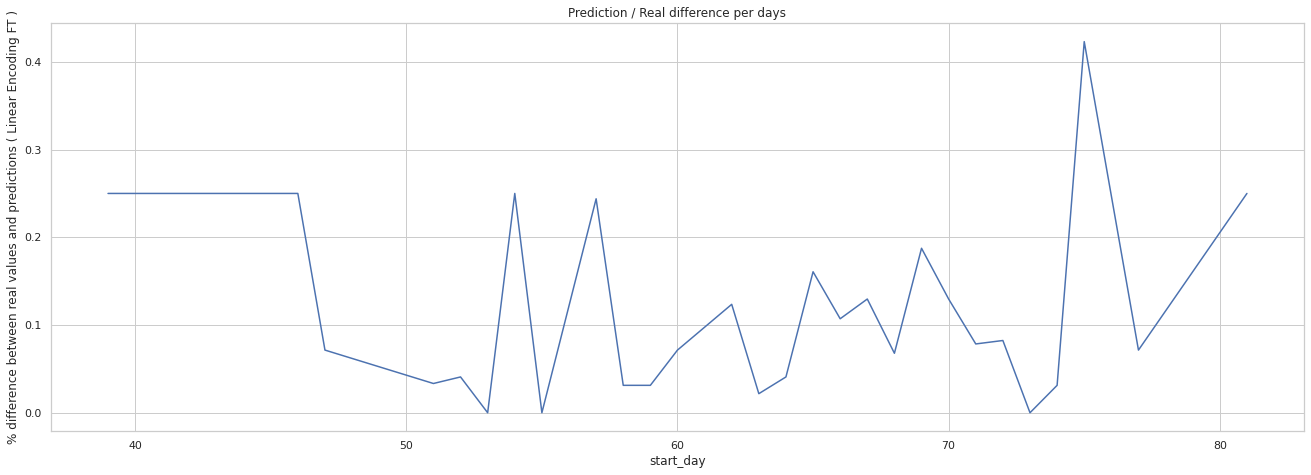

In [102]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

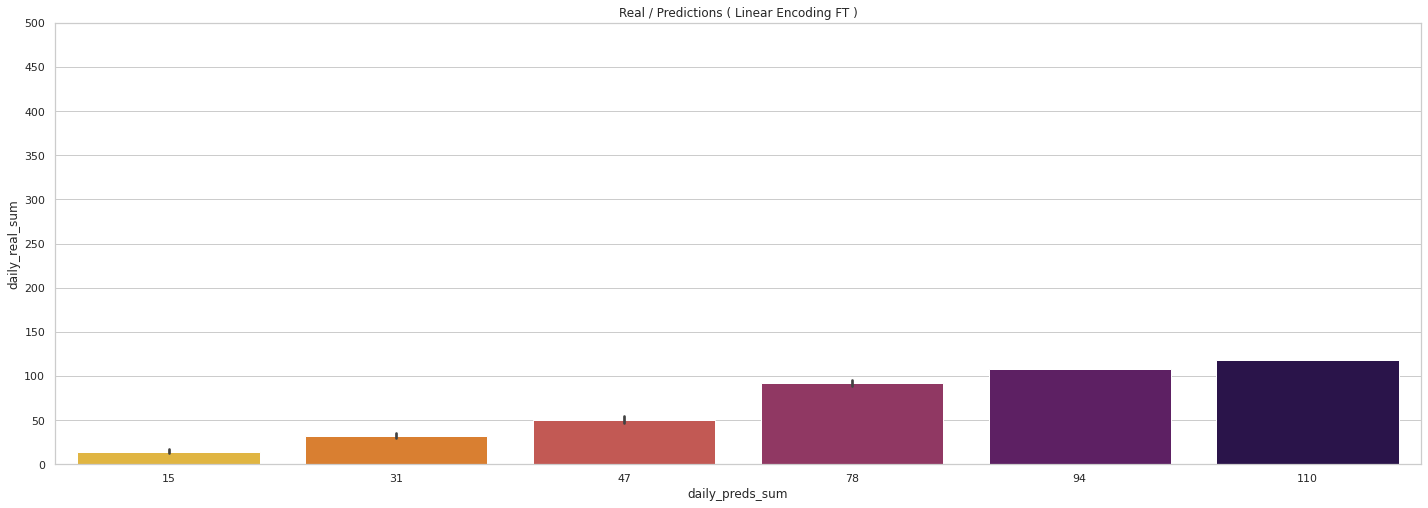

In [103]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

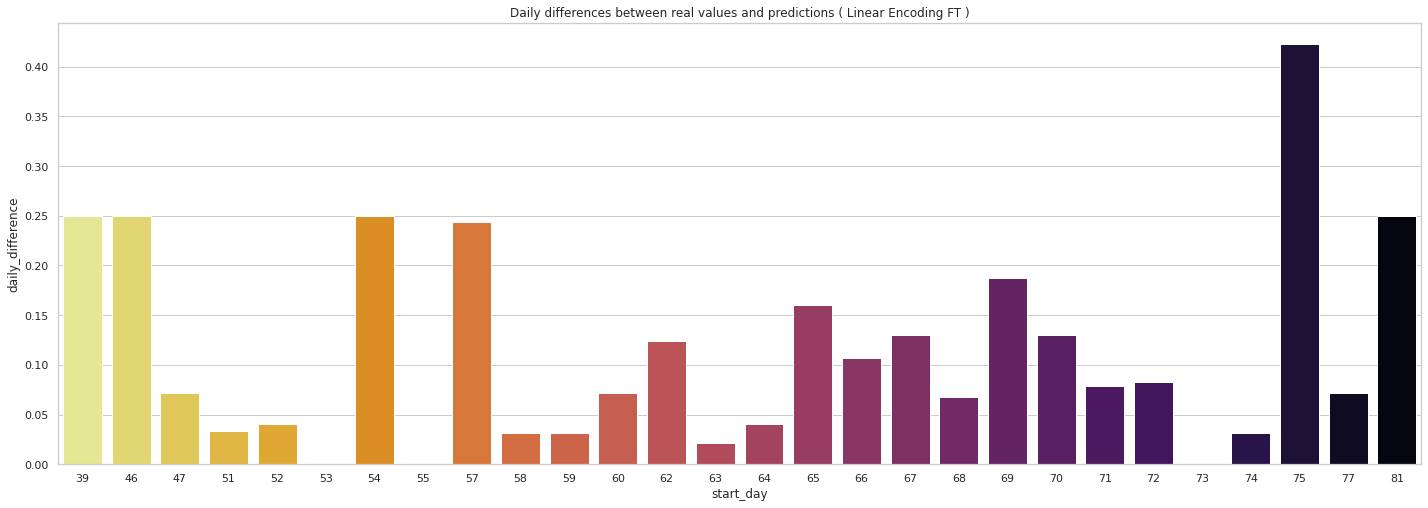

In [104]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [105]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.074840,2.471919,3.353476
Transformer - Periodic Encoding,-0.074840,2.487472,3.365039
LightGBM,0.675832,0.856444,1.841656


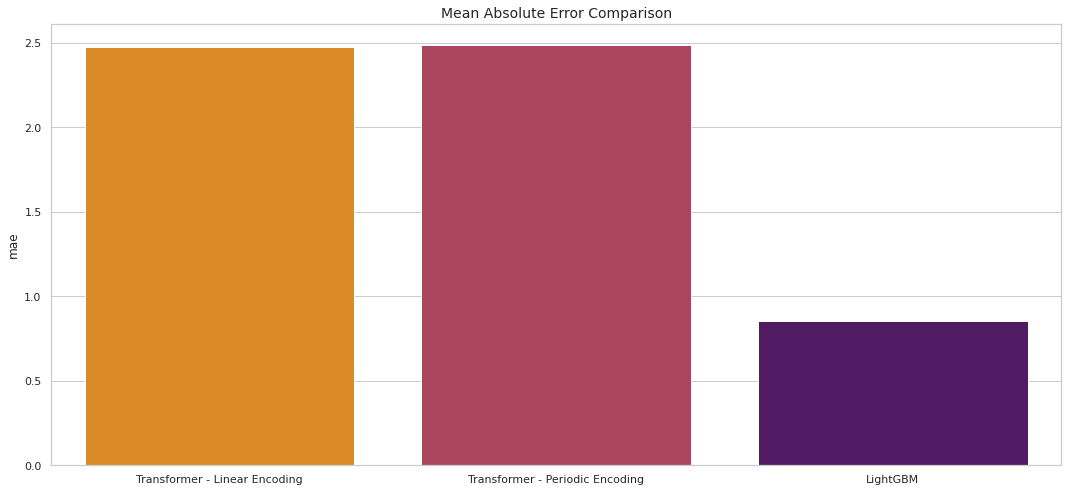

In [106]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


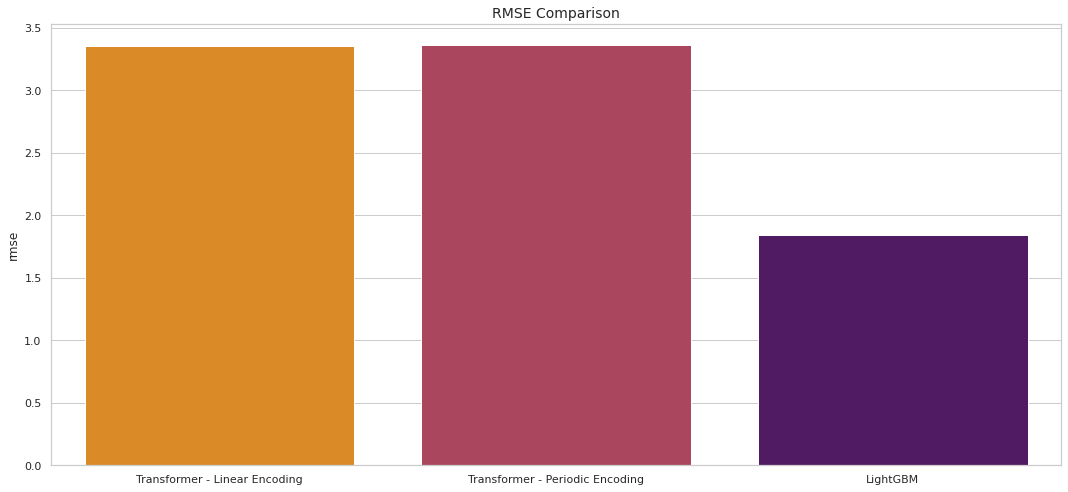

In [107]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


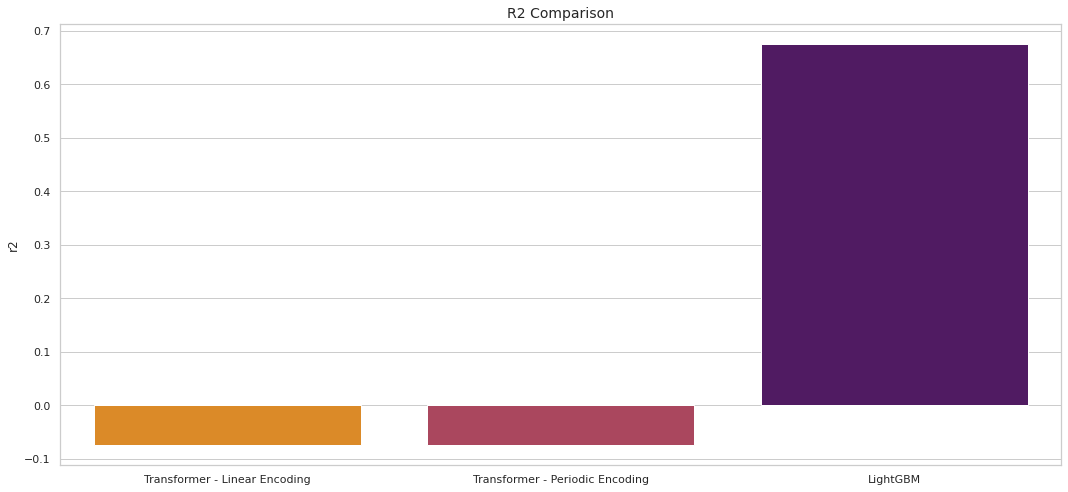

In [108]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [109]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.110011,2.539251,3.407901
Transformer - Periodic Encoding TUNED,-0.082122,2.487706,3.364818
LightGBM TUNED,0.636217,1.060076,1.950942


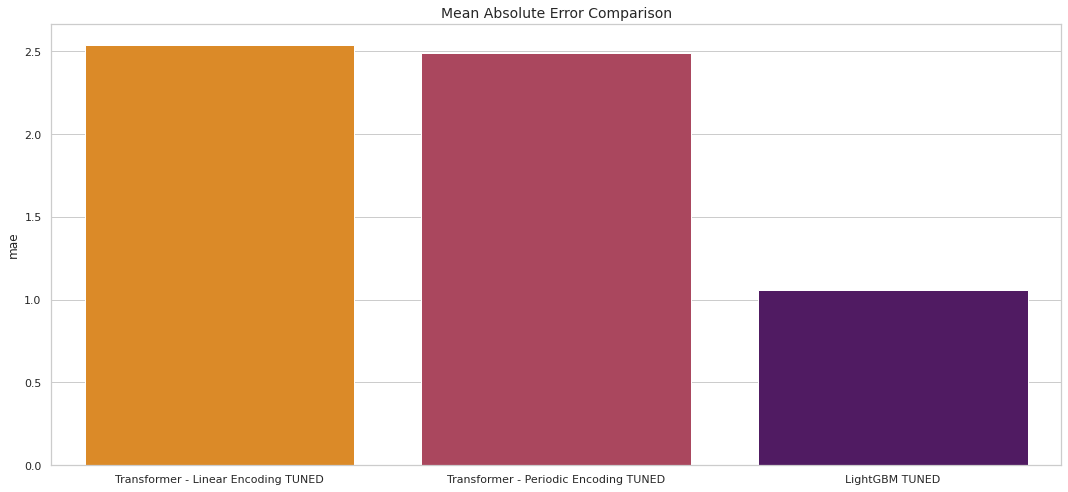

In [110]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


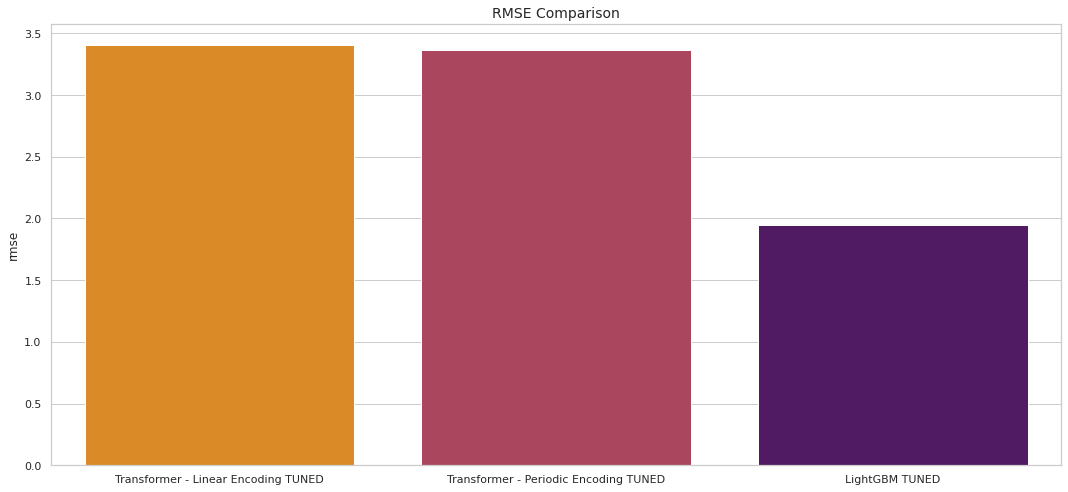

In [111]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


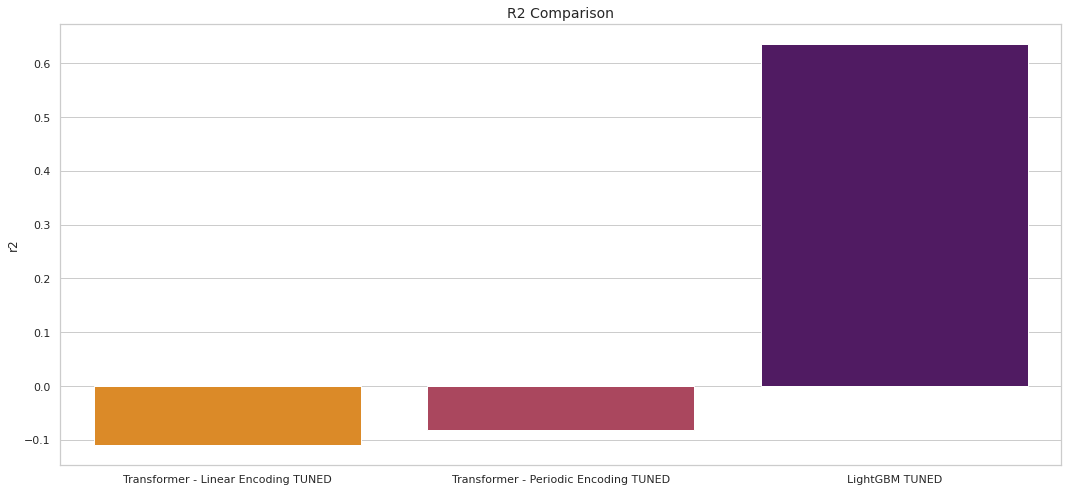

In [112]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
